for all preprocessing needs up until model dev


In [1]:
from pathlib import Path
import sys

# Add repo root and code/ to sys.path
repo_root = Path.cwd().parents[1]
sys.path.insert(0, str(repo_root))
sys.path.insert(0, str(repo_root / "code"))

from utils import helper_functions as hf

In [2]:
# Package import
import scipy.io
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.registration import phase_cross_correlation
import os
import time
import importlib
import torch
import torch.nn.functional as F
import glob
from scipy import signal
import random
import pickle


In [3]:
data_directory = r"C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\secundo"
data_output_dir = r"C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo" # processed data output folder
SPLIT_MODE = 'acq' # Split mode acquistition-wise: 'acq' or middle split per acquisition: 'mid'
HIGH_PASS = 'nohp' # hp for application of highpass filter, nohp (or anything else) for no high pass application
TOP = 99 # top percentile clip (100 for no top clip)
BOTTOM = 1 # bottom percentile clip (0 for no bottom clip)

In [4]:
# Find all matching .mat files
mat_files = glob.glob(os.path.join(data_directory, "*.mat"))
if not mat_files:
    raise ValueError("No files starting with .mat found in the directory!")

print(f"Found {len(mat_files)} files to load...")

# Load all into memory
all_mat_data = {}
for mat_path in mat_files:
    base_name = os.path.splitext(os.path.basename(mat_path))[0]
    print(f"Loading {base_name}")
    all_mat_data[mat_path] = scipy.io.loadmat(mat_path)

print("✅ All .mat files loaded into memory.")

Found 70 files to load...
Loading Datas_Se01072020
Loading Datas_Se01092020
Loading Datas_Se01102020
Loading Datas_Se01122020
Loading Datas_Se02122020
Loading Datas_Se03022020
Loading Datas_Se03092020
Loading Datas_Se04022020
Loading Datas_Se04032020
Loading Datas_Se04062021
Loading Datas_Se04082020
Loading Datas_Se04092020
Loading Datas_Se05022020
Loading Datas_Se05082020
Loading Datas_Se06012020
Loading Datas_Se22092020
Loading Datas_Se22102019
Loading Datas_Se22112019
Loading Datas_Se23072020
Loading Datas_Se24022020
Loading Datas_Se24062020
Loading Datas_Se25062020
Loading Datas_Se25082020
Loading Datas_Se26022021
Loading Datas_Se26062020
Loading Datas_Se27012020
Loading Datas_Se27072020
Loading Datas_Se27082020
Loading Datas_Se27112019
Loading Datas_Se29012020
Loading Datas_Se29062020
Loading Datas_Se29072020
Loading Datas_Se30062020
Loading Datas_Se31012020
Loading Label_pauses_Se01072020
Loading Label_pauses_Se01092020
Loading Label_pauses_Se01102020
Loading Label_pauses_Se01122

In [ ]:
# Quick exploration helpers
sample_path = mat_files[0]
sample = all_mat_data[sample_path]

print("Sample file:", sample_path)
print("Keys:", [k for k in sample.keys() if not k.startswith('__')])

# Show shapes/dtypes for non-meta keys
summary = {}
for k, v in sample.items():
    if k.startswith('__'):
        continue
    summary[k] = (getattr(v, 'shape', None), getattr(v, 'dtype', None))
summary

# Preview 'Datas' if present
if 'Datas' in sample:
    datas = sample['Datas']
    print("Datas shape:", datas.shape, "dtype:", datas.dtype)
    # show one frame (adjust indexing if needed)
    frame = datas[:, :, 0] if datas.ndim == 3 else datas[..., 0]
    plt.imshow(np.log10(frame + 1e-8), cmap='viridis')
    plt.title("Datas preview (log10)")
    plt.colorbar()
    plt.show()
else:
    print("No 'Datas' key in this file.")

# Compare keys across files (helps spot Label_pauses vs Datas)
from collections import Counter
key_sets = [tuple(sorted(k for k in d.keys() if not k.startswith('__'))) for d in all_mat_data.values()]
print("Unique key sets:", Counter(key_sets))

Sample file: C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\secundo\Datas_Se01072020.mat
Keys: ['Data']
No 'Datas' key in this file.
Unique key sets: Counter({('Datas',): 36, ('Data',): 34})


Processing file 0: C:\Users\ESPCI\Documents\GitHub\fUSPredict\sourcedata\secundo\Datas_Se01072020.mat
Available keys: ['Data']
<class 'numpy.ndarray'> float64 (128, 101, 7500)


Text(0.5, 1.0, 'Frame Acquisition 0 (Data)')

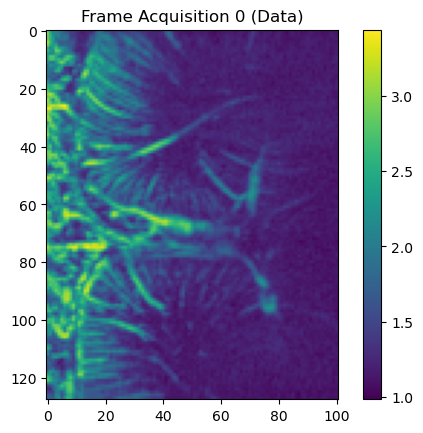

In [43]:
# Quick single-file preview (fast)
file_idx = 0

# Prefer already-loaded data if present; otherwise load one file from disk
if "all_mat_data" in globals() and len(all_mat_data) > 0:
    mat_path = list(all_mat_data.keys())[0]
    mat_data = all_mat_data[mat_path]
else:
    mat_files = glob.glob(os.path.join(data_directory, "*.mat"))
    if len(mat_files) == 0:
        raise ValueError("No .mat files found.")
    mat_path = mat_files[0]
    mat_data = scipy.io.loadmat(mat_path)

print(f"Processing file {file_idx}: {mat_path}")
print("Available keys:", [k for k in mat_data.keys() if not k.startswith('__')])

# Keep it simple: use Doppler if present, otherwise fall back to Datas
key = "Data" if "Data" in mat_data else "Datas"
if key not in mat_data:
    raise KeyError("Neither 'Data' nor 'Datas' found in this file.")
doppler_data = mat_data[key]
fus_struct = doppler_data['fus'][0, 0]   # struct with fields
frames = fus_struct['frame'][0, 0]       # actual numeric array

print(type(frames), frames.dtype, frames.shape)

frame0 = frames[:, :, 0] if frames.ndim == 3 else frames[..., 0]
plt.imshow(np.log10(frame0.astype(np.float32) + 1e-8), cmap='viridis')
plt.colorbar()
plt.title(f"Frame Acquisition {file_idx} ({key})")

# plt.close()

---
### View frame labels over time before baseline filtering

In [19]:
hf = importlib.reload(hf)

  - MISMATCH: Images=7500, Labels=8109. Shaving to 7500 frames.


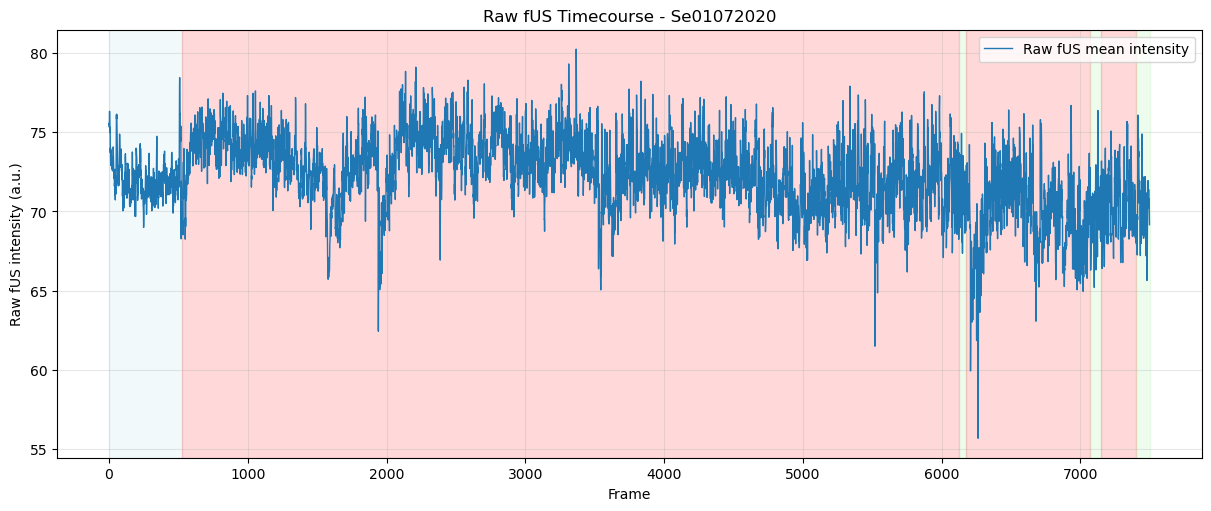

  - MISMATCH: Images=8000, Labels=9294. Shaving to 8000 frames.


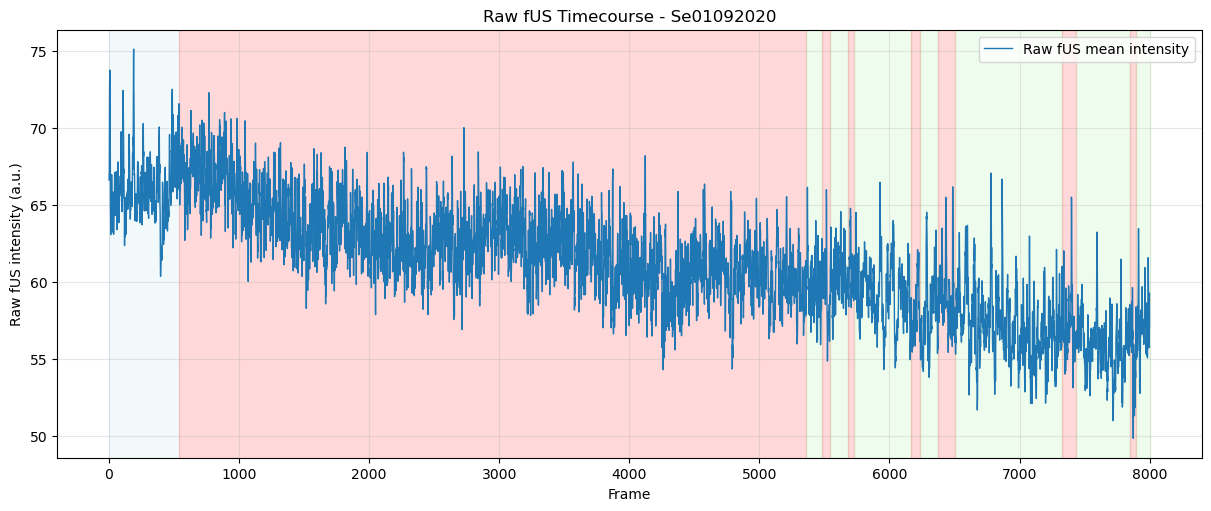

In [21]:
# # All sessions
# hf.plot_fus_timecourse_with_labels(data_directory)

# # One specific session
# hf.plot_fus_timecourse_with_labels(data_directory, sessions="Se01072020")

# A couple sessions
hf.plot_fus_timecourse_with_labels(
    data_directory,
    sessions=["Se01072020", "Se01092020"]
)

---
### Extract and Save Baseline Frames

Extract baseline frames (label == -1) from all sessions and save as per-session .npz files.

In [ ]:
# Set up output directory for baseline files
baseline_output_dir = os.path.join(data_output_dir, "baseline_only")
print(f"Baseline output directory: {baseline_output_dir}")

# Process all files
baseline_files = hf.process_all_baseline_files(data_directory, baseline_output_dir)

Baseline output directory: C:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\preprocessing\secundo\baseline_only
Found 34 fUS files to process

  - MISMATCH: Images=7500, Labels=8109. Shaving to 7500 frames.
✅ Session Se01072020: 526/7500 frames are baseline (7.0%)
  - MISMATCH: Images=8000, Labels=9294. Shaving to 8000 frames.
✅ Session Se01092020: 536/8000 frames are baseline (6.7%)
  - MISMATCH: Images=7500, Labels=9161. Shaving to 7500 frames.
✅ Session Se01102020: 502/7500 frames are baseline (6.7%)
  - MISMATCH: Images=6500, Labels=7543. Shaving to 6500 frames.
✅ Session Se01122020: 538/6500 frames are baseline (8.3%)
  - MISMATCH: Images=6500, Labels=7617. Shaving to 6500 frames.
✅ Session Se02122020: 537/6500 frames are baseline (8.3%)
  - MISMATCH: Images=7500, Labels=8117. Shaving to 7500 frames.
✅ Session Se03022020: 240/7500 frames are baseline (3.2%)
  - MISMATCH: Images=8000, Labels=9249. Shaving to 8000 frames.
✅ Session Se03092020: 518/8000 frames are baseline (6.5

---
### Load Baseline Data

Load baseline sessions for model training.

In [6]:
# Load all baseline sessions
baseline_sessions = hf.load_all_baseline(baseline_output_dir)

# Print summary
if len(baseline_sessions) > 0:
    print(f"\nBaseline Data Summary:")
    print(f"  Total sessions: {len(baseline_sessions)}")
    total_frames = sum(s['frames'].shape[0] for s in baseline_sessions)
    print(f"  Total baseline frames: {total_frames:,}")
    
    spatial_shapes = [s['frames'].shape[1:] for s in baseline_sessions]
    unique_shapes = set(spatial_shapes)
    print(f"  Spatial dimensions: {unique_shapes}")
    
    # Show frame count distribution
    frame_counts = [s['frames'].shape[0] for s in baseline_sessions]
    print(f"  Frames per session: min={min(frame_counts)}, max={max(frame_counts)}, "
          f"mean={np.mean(frame_counts):.0f}, std={np.std(frame_counts):.0f}")
    
    # first session
    if len(baseline_sessions) > 0:
        first_session = baseline_sessions[0]
        print(f"\n  First session ({first_session['session_id']}):")
        print(f"    Frames: {first_session['frames'].shape[0]}")
        print(f"    Shape: {first_session['frames'].shape}")
        print(f"    Dtype: {first_session['frames'].dtype}")
        print(f"    Value range: [{first_session['frames'].min():.2f}, {first_session['frames'].max():.2f}]")

✅ Loaded 34 baseline sessions

Baseline Data Summary:
  Total sessions: 34
  Total baseline frames: 14,043
  Spatial dimensions: {(128, 107), (128, 91), (128, 132), (128, 122), (128, 112), (128, 96), (128, 101)}
  Frames per session: min=1, max=906, mean=413, std=202

  First session (Se01072020):
    Frames: 526
    Shape: (526, 128, 101)
    Dtype: float32
    Value range: [9.31, 3374.84]


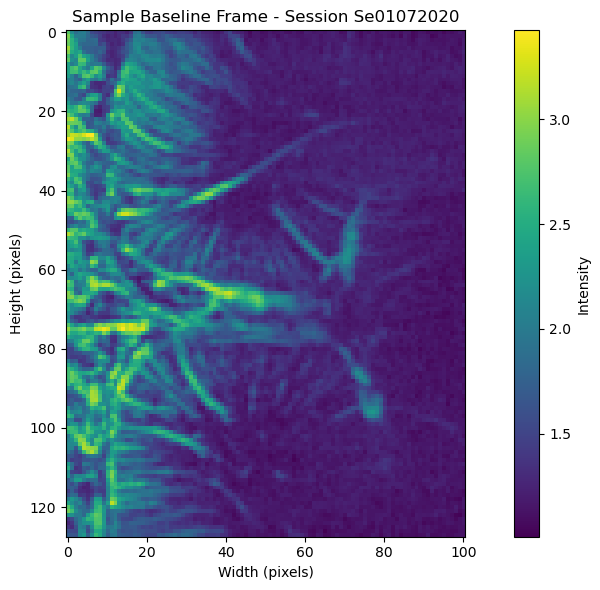

Frame shape: (128, 101)
Frame stats: min=10.20, max=2652.38, mean=73.28, std=165.47


In [14]:
# Visualize a sample baseline frame from first session
if len(baseline_sessions) > 0:
    sample_session = baseline_sessions[0]
    sample_frame = sample_session['frames'][200]  # First frame
    
    plt.figure(figsize=(10, 6))
    # plt.imshow(sample_frame, cmap='viridis')
    plt.imshow(np.log10(sample_frame.astype(np.float32) + 1e-8), cmap='viridis')
    plt.colorbar(label='Intensity')
    plt.title(f"Sample Baseline Frame - Session {sample_session['session_id']}")
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.tight_layout()
    plt.show()
    
    print(f"Frame shape: {sample_frame.shape}")
    print(f"Frame stats: min={sample_frame.min():.2f}, max={sample_frame.max():.2f}, "
          f"mean={sample_frame.mean():.2f}, std={sample_frame.std():.2f}")

---